In [1]:
from IPython import display
import time
import tensorflow as tf
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from skimage import transform, io, color
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid': False})

In [2]:
data_info = pd.read_csv('drivedata/driving_log.csv',
                        names=['img_center', 'img_left', 'img_right',
                               'steer_angle', 'throttle', 'brake', 'speed'],
                        sep=', ')
data_info.reindex(np.random.permutation(data_info.index)).reset_index(drop=True)

data_info_test = pd.read_csv('drivedata_test/driving_log.csv',
                             names=['img_center', 'img_left', 'img_right',
                                    'steer_angle', 'throttle', 'brake', 'speed'],
                             sep=', ')
data_info_test.reindex(np.random.permutation(data_info_test.index)).reset_index(drop=True)

MAX_INDEX = len(data_info)
print(MAX_INDEX)
MAX_INDEX_TEST = int(len(data_info_test)/4)
print(MAX_INDEX_TEST)

img_index = ['img_left', 'img_center', 'img_right']

5795
407


/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [3]:
data_info['img_center'][1]

'/home/naotoyoshida/udacity/Self-Driving-Car-Behavior-Cloning/drivedata/IMG/center_2017_01_25_21_28_47_136.jpg'

(160, 320, 3)


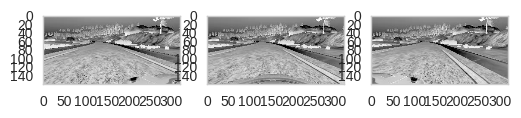

In [4]:
img = io.imread(data_info['img_left'][0])
plt.subplot(1,3,1)
plt.imshow(color.rgb2grey(img))

img = io.imread(data_info['img_center'][0])
plt.subplot(1,3,2)
plt.imshow(color.rgb2grey(img))

img = io.imread(data_info['img_right'][0])
plt.subplot(1,3,3)
plt.imshow(color.rgb2grey(img))
print(img.shape)

In [5]:
"""
img = io.imread(data_info['img_left'][0])
plt.subplot(1,3,1)
img = color.rgb2grey(transform.resize(img, output_shape=[42, 84]))
plt.imshow(img)

img = io.imread(data_info['img_center'][0])
plt.subplot(1,3,2)
img = color.rgb2grey(transform.resize(img, output_shape=[42, 84]))
plt.imshow(img)

img = io.imread(data_info['img_right'][0])
plt.subplot(1,3,3)
img = color.rgb2grey(transform.resize(img, output_shape=[42, 84]))
plt.imshow(img)
print(img.shape)
"""

"\nimg = io.imread(data_info['img_left'][0])\nplt.subplot(1,3,1)\nimg = color.rgb2grey(transform.resize(img, output_shape=[42, 84]))\nplt.imshow(img)\n\nimg = io.imread(data_info['img_center'][0])\nplt.subplot(1,3,2)\nimg = color.rgb2grey(transform.resize(img, output_shape=[42, 84]))\nplt.imshow(img)\n\nimg = io.imread(data_info['img_right'][0])\nplt.subplot(1,3,3)\nimg = color.rgb2grey(transform.resize(img, output_shape=[42, 84]))\nplt.imshow(img)\nprint(img.shape)\n"

In [6]:
data_info.shape

(5795, 7)

In [7]:
# Parameters

IMG_SIZE = (160, 320)
CHANNEL_SIZE = 3
BATCH_SIZE = 64
TEST_BATCH = 64
N_EPOCH = 1500

In [8]:
# Utility Functions

def get_formatted_image(image):
    return color.rgb2grey(io.imread(image))

def get_image_and_target(index_data, is_test=False):
    X_img = np.ndarray(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    if is_test is True:
        data_info_ = data_info_test
    else:
        data_info_ = data_info
        
    for i, index in enumerate(img_index):
        data = data_info_[index][i]
        img = get_formatted_image(data)
        X_img[:,:,i] = img
    
    y_target = [data_info_['steer_angle'][index_data]]#, data_info['throttle'][index], data_info['brake'][index]]
    return np.array(X_img, dtype=np.float32), np.array(y_target, dtype=np.float32)

x, y = get_image_and_target(0, data_info)
print(x.shape)
print(y.shape)

def get_batch_data(offset, is_test=False, batch_size=32):
    if is_test is True:
        data_info_ = data_info_test
        max_index = MAX_INDEX_TEST
    else:
        data_info_ = data_info
        max_index = MAX_INDEX
    
    if offset > int(max_index/batch_size):
        print("offset is too large!!!")
    X = []
    Y = []
    for i in range(batch_size):
        index = offset*batch_size + i
        if index >= max_index:
            break
        else:
            x, y = get_image_and_target(index, data_info_)
            X.append(x)
            Y.append(y)
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

print(int(MAX_INDEX/32))
index = len(data_info)
X, y = get_batch_data(181, data_info)
print(X.shape)
print(y.shape)

(160, 320, 3)
(1,)
181
(3, 160, 320, 3)
(3, 1)


In [13]:
# Train by keras anyway
import tensorflow as tf
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Convolution2D(64, 8, 8,
                        W_regularizer=l2(0.000001),
                        border_mode='valid',
                        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                        dim_ordering="tf",
                        subsample=(4,4)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, 8, 8,
                        W_regularizer=l2(0.000001),
                        dim_ordering="tf",
                        subsample=(4,4)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(400))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('tanh'))

In [14]:
from keras.optimizers import Adam

optimizer = Adam(lr=0.0001, epsilon=0.0001)
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['accuracy'])

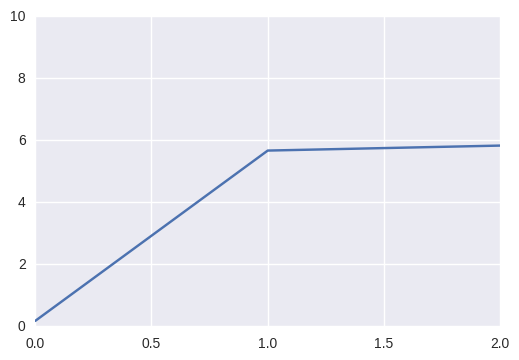

Epoch : 2 : Test Loss : 5.82880574464798 : Accuracy : 0.0


In [ ]:
test_loss_list = []
test_accuracy_list = []
train_loss_list = []
train_accuracy_list = []

def evaluation():
    test_loss_ = 0.0
    test_accuracy_ = 0.0
    N = int(MAX_INDEX_TEST/TEST_BATCH)
    for i in range(N):
        X, Y = get_batch_data(offset=i, is_test=True)
        test_loss, test_accuracy = model.test_on_batch(x=X, y=Y)
        test_loss_ += test_loss
        test_accuracy_ += test_accuracy
    return test_loss_, test_accuracy_/N

sns.set_style("darkgrid", {'axes.grid': True})
for nb_epoch in range(N_EPOCH):
    data_info.reindex(np.random.permutation(data_info.index)).reset_index(drop=True)
    for i in range(int(MAX_INDEX/BATCH_SIZE)):
        X, Y = get_batch_data(offset=i, is_test=False)
        train_loss, train_accuracy = model.train_on_batch(x=X, y=Y)
        
    test_loss, test_accuracy = evaluation()

    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    #train_loss_list.append(train_loss)
    #train_accuracy_list.append(train_accuracy)

    plt.gca().cla() 
    plt.plot(test_loss_list)
    plt.ylim([0, 10.0])
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(0.1) 
    print("Epoch : {} : Test Loss : {} : Accuracy : {}".format(nb_epoch, test_loss, test_accuracy))

    model.save('model.h5') 

In [12]:
"""
from keras.applications.vgg19 import VGG19

base_model = VGG19(weights='imagenet')

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)
"""

"\nfrom keras.applications.vgg19 import VGG19\n\nbase_model = VGG19(weights='imagenet')\n\nfor i, layer in enumerate(base_model.layers):\n    print(i, layer.name)\n"